# arquitectura CNN

### Resumen del capítulo: **Filtering a Time Series with CNN**

#### Introducción
- En este capítulo se explora el uso de **redes neuronales convolucionales (CNN)** para filtrar ruido en series temporales y generar características robustas.
- Las CNNs, comúnmente aplicadas en visión por computadora, también son útiles en análisis de series temporales debido a su resistencia al ruido y rapidez en entrenamiento.
- Se combina la arquitectura CNN con LSTM para mejorar el rendimiento en modelos de aprendizaje profundo.

---

#### **16.1 Arquitectura de las redes neuronales convolucionales (CNN)**

##### ¿Qué es una CNN?
- Una CNN es una arquitectura de aprendizaje profundo que utiliza la operación de convolución para reducir el espacio de características.
- La convolución actúa como un regularizador, previniendo el sobreajuste y filtrando valores anómalos.

##### **Operación de convolución**
- Matemáticamente, la convolución combina dos funciones para generar una tercera, que refleja cómo una función altera la otra.
- En una CNN, la convolución ocurre entre:
  - **Matriz de características** (inputs).
  - **Kernel o filtro** (matriz más pequeña que se optimiza durante el entrenamiento).

##### **Proceso**
1. El kernel se desliza a lo largo de la dimensión del tiempo (stride), calculando el producto punto entre los valores alineados.
2. Este proceso genera un vector de salida reducido.
   - **Longitud del vector de salida**:  
     \[
     \text{output\_length} = \text{input\_length} - \text{kernel\_length} + 1
     \]

##### **Convolución en Keras**
- Keras provee la capa `Conv1D` para implementar convoluciones unidimensionales, ideales para series temporales.

---

##### **Problema: Reducción excesiva del espacio de características**
- Realizar múltiples convoluciones reduce drásticamente el espacio de características, pudiendo causar pérdida de información.
- **Solución: Padding**
  - Se añaden ceros antes y después del vector de entrada para mantener la dimensión de salida igual a la de entrada.
  - Permite apilar más capas de convolución, procesando características por más tiempo.

---

#### Ventajas de las CNN para series temporales
1. **Filtrado del ruido**: Extraen características robustas y eliminan valores anómalos.
2. **Regularización**: Reducen el riesgo de sobreajuste gracias a la convolución.
3. **Rapidez**: Son más rápidas de entrenar que las LSTM debido a su paralelización.
4. **Flexibilidad con padding**: Facilita el uso de redes más profundas.

---

#### Implementación
- **Paso siguiente**: Usar Keras para construir un modelo CNN que pronostique series temporales.
- Combinación con LSTM: Evaluar si la integración de ambas arquitecturas mejora el rendimiento de los modelos.

----

### Que es la convolucion ? 

En terminos intuitivos ...

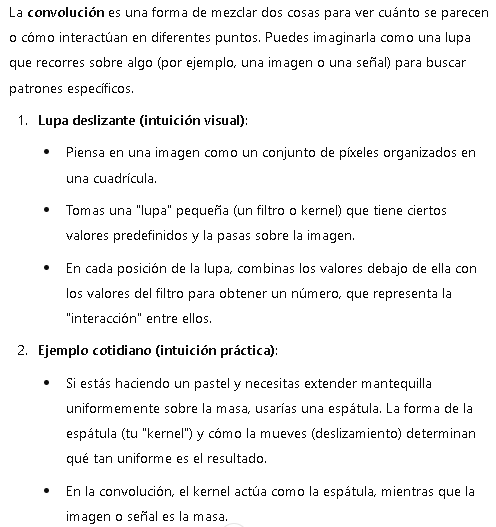

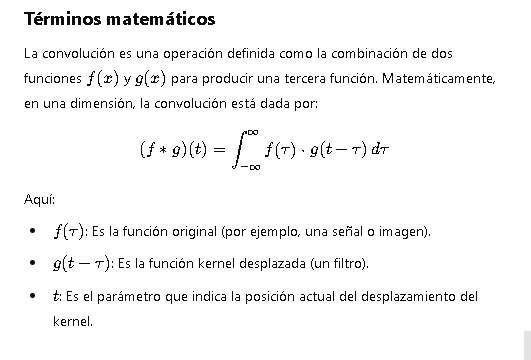

La convolución puede interpretarse como un método eficiente y vectorizado para realizar ingeniería de características sobre datos temporales (series temporales) o espaciales (imágenes). Aquí te dejo una explicación detallada:



## Examinando la arquitectura CNN

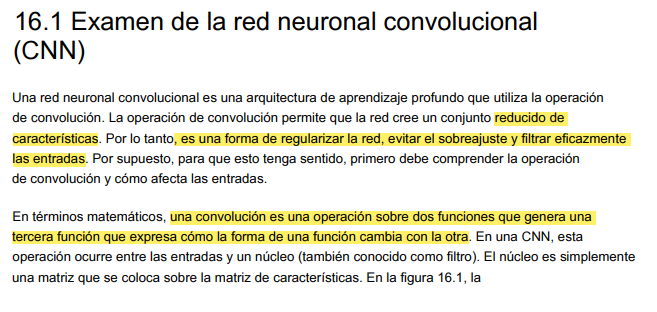


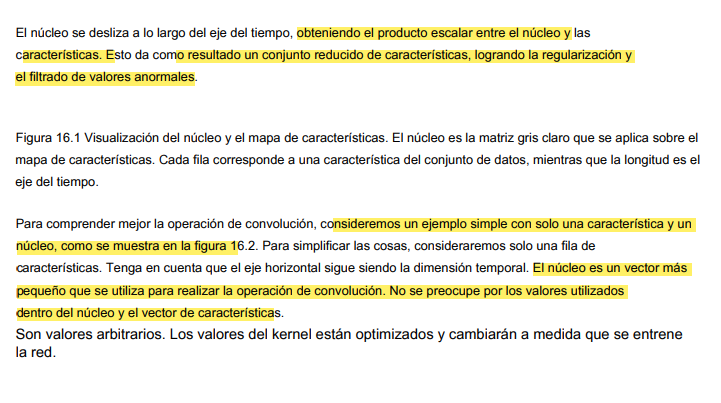

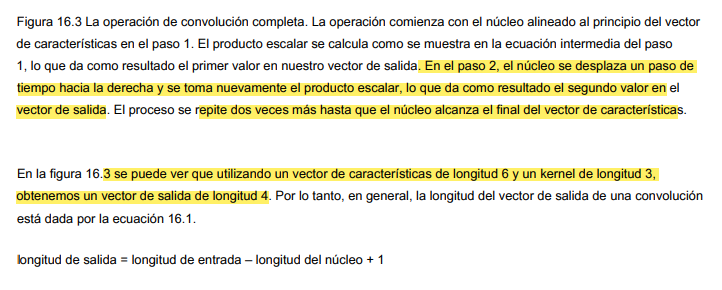

# CNN:

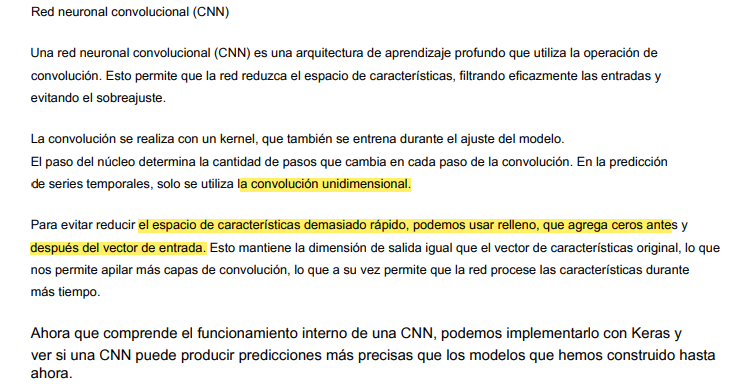

In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.6.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('../data/train.csv', index_col=0)
val_df = pd.read_csv('../data/val.csv', index_col=0)
test_df = pd.read_csv('../data/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [6]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions', c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32)
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [7]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## CNN 

### Single-step model 

en este caso no tiene sentido proporcionar al modelo CNN solo un paso de tiempo como entrada 
porque queremos ejecutar una convolución. En su lugar, utilizaremos tres valores de entrada para generar una 
predicción para el siguiente paso de tiempo. De esa manera, tendremos una secuencia de datos en la que 
podemos ejecutar una operación de convolución. Además, nuestra secuencia de entrada debe tener una longitud al 
menos igual a la longitud del núcleo, que en nuestro caso es 3

longitud de salida = longitud de entrada – longitud del núcleo + 1

In [9]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

conv_window = DataWindow(input_width=KERNEL_WIDTH, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['traffic_volume'])

In [10]:
# VALORES OBTENIDOS DEL CAPITULO 15 DE time series forecasting. de manning

mae_val = [0.083, 0.068, 0.033, 0.03]
mae_test = [0.081, 0.068, 0.029, 0.026]

In [11]:
cnn_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance = {}
performance = {}

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 2s 2ms/step - loss: 0.0193 - mean_absolute_error: 0.0879 - val_loss: 0.0051 - val_mean_absolute_error: 0.0523
Epoch 2/50
384/384 [==============================] - 0s 930us/step - loss: 0.0051 - mean_absolute_error: 0.0525 - val_loss: 0.0042 - val_mean_absolute_error: 0.0481
Epoch 3/50
384/384 [==============================] - 0s 896us/step - loss: 0.0045 - mean_absolute_error: 0.0490 - val_loss: 0.0038 - val_mean_absolute_error: 0.0458
Epoch 4/50
384/384 [==============================] - 0s 906us/step - loss: 0.0041 - mean_absolute_error: 0.0467 - val_loss: 0.0037 - val_mean_absolute_error: 0.0453
Epoch 5/50
384/384 [==============================] - 0s 909us/step - loss: 0.0038 - mean_absolute_error: 0.0448 - val_loss: 0.0032 - val_mean_absolute_error: 0.0428
Epoch 6/50
384/384 [==============================] - 0s 906us/step - loss: 0.0035 - mean_absolute_error: 0.0428 - val_loss: 0.0028 - val_mean_absolute_error: 0.0395
Epoch 

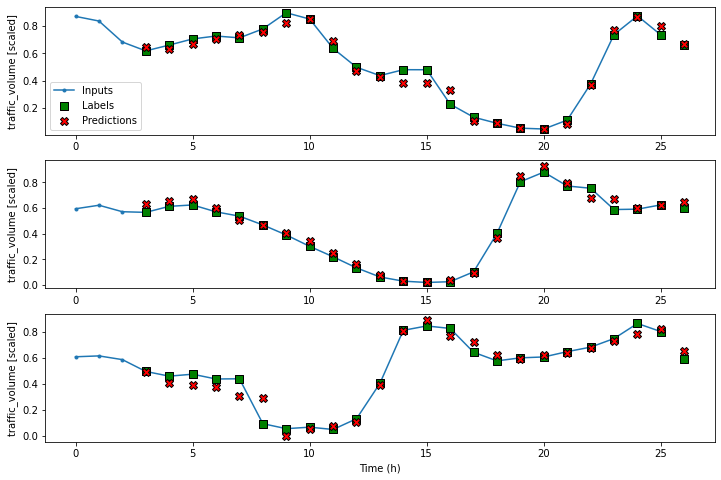

In [12]:
wide_conv_window.plot(cnn_model)

plt.savefig('figures/CH16_F05_peixeiro.png', dpi=300)

#### CNN + LSTM 

In [13]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
          kernel_size=(KERNEL_WIDTH,),
          activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 3s 3ms/step - loss: 0.0295 - mean_absolute_error: 0.1117 - val_loss: 0.0069 - val_mean_absolute_error: 0.0611
Epoch 2/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0062 - mean_absolute_error: 0.0572 - val_loss: 0.0049 - val_mean_absolute_error: 0.0510
Epoch 3/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0046 - mean_absolute_error: 0.0498 - val_loss: 0.0039 - val_mean_absolute_error: 0.0460
Epoch 4/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0037 - mean_absolute_error: 0.0448 - val_loss: 0.0032 - val_mean_absolute_error: 0.0447
Epoch 5/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0033 - mean_absolute_error: 0.0414 - val_loss: 0.0028 - val_mean_absolute_error: 0.0385
Epoch 6/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0031 - mean_absolute_error: 0.0397 - val_loss: 0.0026 - val_mean_absolute_error: 0.0391
Epoch 7/50
384/3

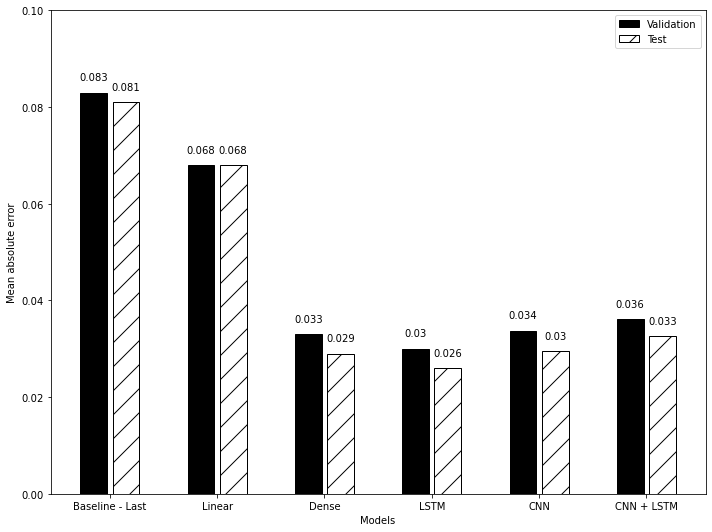

In [14]:
mae_val.extend([v[1] for v in val_performance.values()])
mae_test.extend([v[1] for v in performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH16_F06_peixeiro.png', dpi=300)

### Multi-step model 

In [15]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=24, label_columns=['traffic_volume'])

In [16]:
# Values obtained from chapter 15

ms_mae_val = [0.352, 0.347, 0.088, 0.078, 0.070]
ms_mae_test = [0.347, 0.341, 0.076, 0.064, 0.058]

In [17]:
ms_cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['CNN'] = ms_cnn_model.evaluate(multi_window.val)
ms_performance['CNN'] = ms_cnn_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 1s 2ms/step - loss: 0.0345 - mean_absolute_error: 0.1229 - val_loss: 0.0163 - val_mean_absolute_error: 0.0857
Epoch 2/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0141 - mean_absolute_error: 0.0791 - val_loss: 0.0157 - val_mean_absolute_error: 0.0828
Epoch 3/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0137 - mean_absolute_error: 0.0778 - val_loss: 0.0157 - val_mean_absolute_error: 0.0869
Epoch 4/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0134 - mean_absolute_error: 0.0772 - val_loss: 0.0149 - val_mean_absolute_error: 0.0802
Epoch 5/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0133 - mean_absolute_error: 0.0767 - val_loss: 0.0148 - val_mean_absolute_error: 0.0820
Epoch 6/50
383/383 [==============================] - 1s 1ms/step - loss: 0.0131 - mean_absolute_error: 0.0760 - val_loss: 0.0145 - val_mean_absolute_error: 0.0802
Epoch 7/50
383/3

#### CNN + LSTM 

In [18]:
ms_cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_cnn_lstm_model, multi_window)

ms_val_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.val)
ms_performance['CNN + LSTM'] = ms_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 [==============================] - 4s 6ms/step - loss: 0.0399 - mean_absolute_error: 0.1399 - val_loss: 0.0174 - val_mean_absolute_error: 0.0921
Epoch 2/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0145 - mean_absolute_error: 0.0816 - val_loss: 0.0159 - val_mean_absolute_error: 0.0834
Epoch 3/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0138 - mean_absolute_error: 0.0778 - val_loss: 0.0154 - val_mean_absolute_error: 0.0809
Epoch 4/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0134 - mean_absolute_error: 0.0763 - val_loss: 0.0151 - val_mean_absolute_error: 0.0812
Epoch 5/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0130 - mean_absolute_error: 0.0751 - val_loss: 0.0153 - val_mean_absolute_error: 0.0782absolute_error: 0
Epoch 6/50
383/383 [==============================] - 2s 6ms/step - loss: 0.0128 - mean_absolute_error: 0.0745 - val_loss: 0.0144 - val_mean_absolute_error: 0.0773

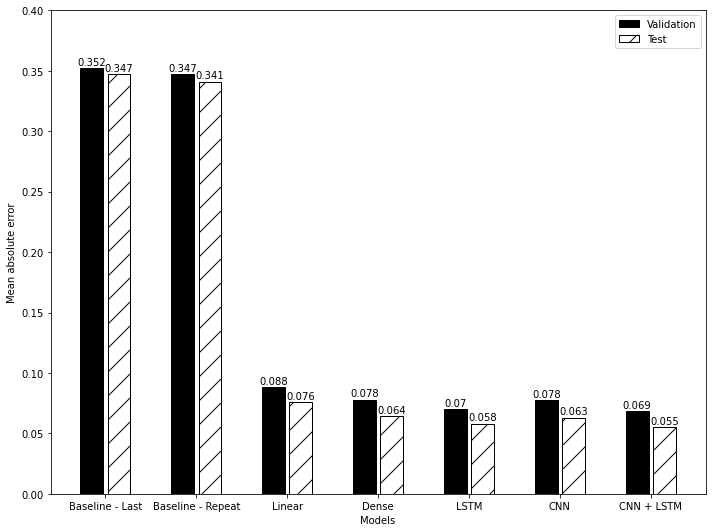

In [19]:
ms_mae_val.extend([v[1] for v in ms_val_performance.values()])
ms_mae_test.extend([v[1] for v in ms_performance.values()])

x = np.arange(7)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH16_F07_peixeiro.png', dpi=300)

### Multi-output model 

In [20]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

wide_mo_conv_window = DataWindow(input_width=INPUT_WIDTH, label_width=24, shift=1, label_columns=['temp', 'traffic_volume'])

In [21]:
# Values from chapter 15

mo_mae_val = [0.048, 0.039, 0.023, 0.020]
mo_mae_test = [0.047, 0.036, 0.020, 0.017]

In [23]:
mo_cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_model, wide_mo_conv_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 1s 2ms/step - loss: 0.0168 - mean_absolute_error: 0.0742 - val_loss: 0.0031 - val_mean_absolute_error: 0.0363
Epoch 2/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0028 - mean_absolute_error: 0.0332 - val_loss: 0.0022 - val_mean_absolute_error: 0.0305
Epoch 3/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_absolute_error: 0.0305 - val_loss: 0.0019 - val_mean_absolute_error: 0.0283
Epoch 4/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0021 - mean_absolute_error: 0.0281 - val_loss: 0.0016 - val_mean_absolute_error: 0.0257
Epoch 5/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0018 - mean_absolute_error: 0.0263 - val_loss: 0.0015 - val_mean_absolute_error: 0.0243
Epoch 6/50
384/384 [==============================] - 1s 1ms/step - loss: 0.0017 - mean_absolute_error: 0.0252 - val_loss: 0.0014 - val_mean_absolute_error: 0.0246
Epoch 7/50
384/3

In [25]:
mo_cnn_lstm_model = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_WIDTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(units=2)
])

history = compile_and_fit(mo_cnn_lstm_model, wide_mo_conv_window)

mo_val_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.val)
mo_performance['CNN + LSTM'] = mo_cnn_model.evaluate(wide_mo_conv_window.test, verbose=0)

Epoch 1/50
384/384 [==============================] - 4s 7ms/step - loss: 0.0236 - mean_absolute_error: 0.0956 - val_loss: 0.0048 - val_mean_absolute_error: 0.0455
Epoch 2/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0381 - val_loss: 0.0026 - val_mean_absolute_error: 0.0367
Epoch 3/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0023 - mean_absolute_error: 0.0317 - val_loss: 0.0021 - val_mean_absolute_error: 0.0310
Epoch 4/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0020 - mean_absolute_error: 0.0289 - val_loss: 0.0016 - val_mean_absolute_error: 0.0269
Epoch 5/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0018 - mean_absolute_error: 0.0274 - val_loss: 0.0015 - val_mean_absolute_error: 0.0260
Epoch 6/50
384/384 [==============================] - 2s 6ms/step - loss: 0.0017 - mean_absolute_error: 0.0264 - val_loss: 0.0014 - val_mean_absolute_error: 0.0252
Epoch 7/50
384/3

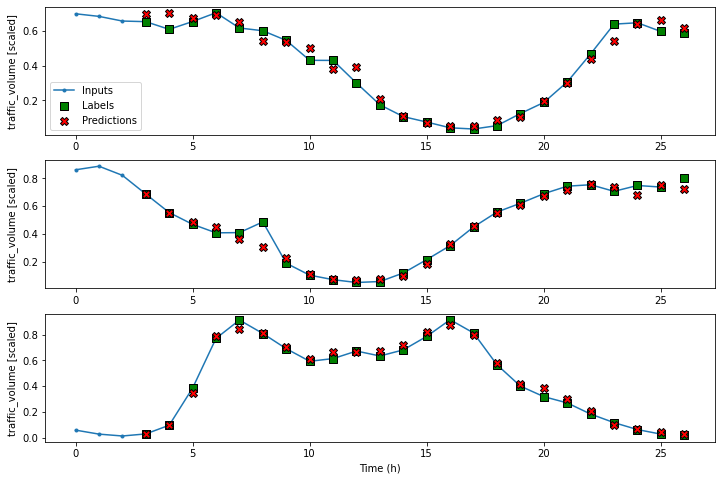

In [26]:
wide_mo_conv_window.plot(mo_cnn_lstm_model)

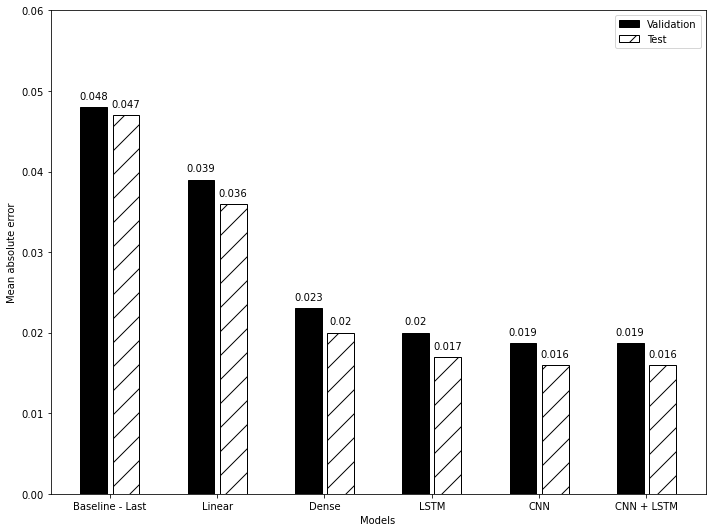

In [27]:
mo_mae_val.extend([v[1] for v in mo_val_performance.values()])
mo_mae_test.extend([v[1] for v in mo_performance.values()])

x = np.arange(6)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM', 'CNN', 'CNN + LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH16_F08_peixeiro.png', dpi=300)